In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as metrics
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# !pip install pystan fbprophet
from fbprophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = '/content/drive/My Drive/data/apple_series/AAPL.csv'
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56

In [ ]:
df = pd.read_csv(data_root)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual,Dynamic
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600,0.128627,0.121931,0.000000
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800,0.121931,0.113002,-0.000558
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000,0.113002,0.115792,-0.000558
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600,0.115792,0.119141,0.000000
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600,0.119141,0.126395,0.000000


In [ ]:
df['Mean'] = (df.Low + df.High) / 2

In [ ]:
df['Actual'] = df.Mean.shift(-1)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', drop=True, inplace=True)

In [ ]:
df = df.iloc[6826:, :]  # because model cannot learn well from almost constant period from 1980 to 2008

In [ ]:
df['Dynamic'] = df.Close - df.Open

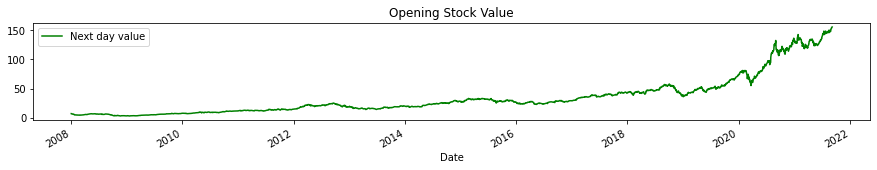

In [ ]:
df['Mean'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title('Opening Stock Value')
plt.show()

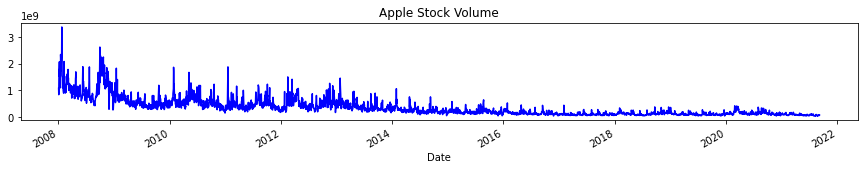

In [ ]:
df['Volume'].plot(color='blue', figsize=(15,2))
plt.title('Apple Stock Volume')
plt.show()

In [ ]:
sc_in = MinMaxScaler(feature_range=(0, 1))
X = sc_in.fit_transform(df.drop('Actual', axis=1))
X = pd.DataFrame(X, columns=[column for column in df.columns if column != 'Actual'], index=df.index)

In [ ]:
y = pd.DataFrame(df.Actual, index=df.index)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

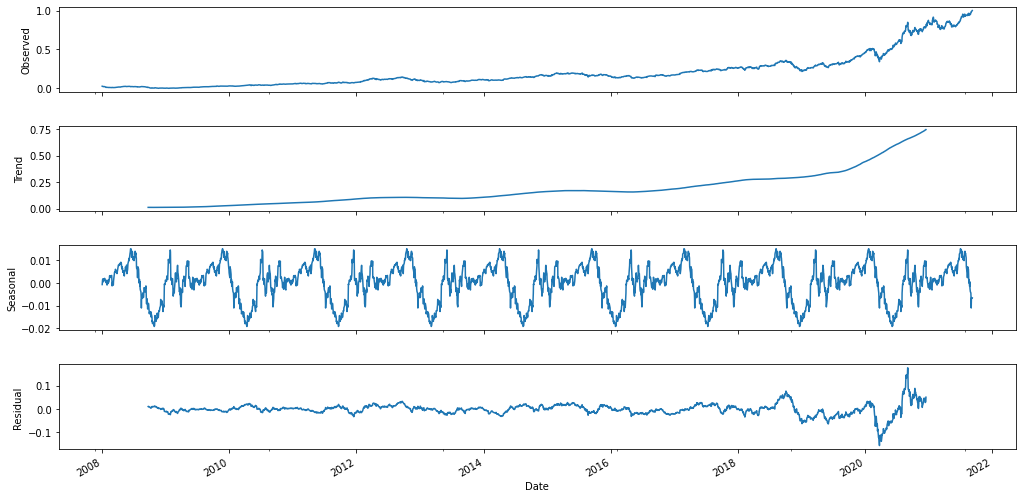

In [ ]:
decompose = seasonal_decompose(X.Mean, model='additive', freq=365)
# decompose = seasonal_decompose(X.Mean, model='additive', period=365)
fig = decompose.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [ ]:
dftest = adfuller(y_train.Actual, autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))
# no stational

{'adf': -2.4672694768117256,
 'criticalvalues': {'1%': -3.962534505309028,
  '10%': -3.1281244326590665,
  '5%': -3.412314817407338},
 'icbest': 432.2285685059669,
 'nobs': 2408,
 'pvalue': 0.3445148016936266,
 'usedlag': 2}

In [ ]:
dftest = adfuller(y_train.Actual.diff().dropna(), autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))
# we have stationarity, d=1

{'adf': -33.81780751640671,
 'criticalvalues': {'1%': -3.962534505309028,
  '10%': -3.1281244326590665,
  '5%': -3.412314817407338},
 'icbest': 436.41085768225184,
 'nobs': 2408,
 'pvalue': 0.0,
 'usedlag': 1}

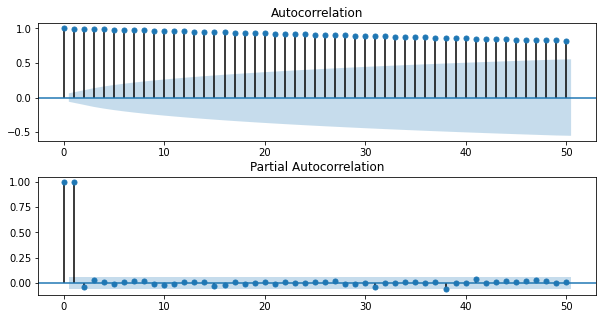

In [ ]:
# non-stationary data
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(y_test, lags=50, ax=ax[0])
fig = plot_pacf(y_test, lags=50, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
# q = 1 (as if lag=1 is max external, then cut-off, so data explained in lag=1), 
# p = 0? no cut-off (max external lag value out of confidence intervals) 

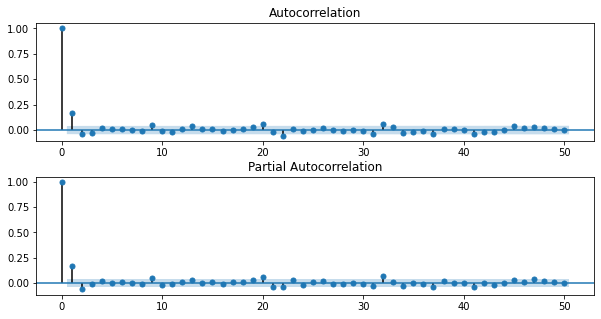

In [ ]:
# stationary data
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(y_train.diff().dropna(), lags=50, ax=ax[0])
fig = plot_pacf(y_train.diff().dropna(), lags=50, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
# also apply fuller test for Seasonal_Difference (D parameter)

In [ ]:
step_wise = auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,  max_p=7, max_q=7,  d=1, max_d=7, trend='ct',
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-37.436, Time=4.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.859, Time=2.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38.912, Time=2.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.583, Time=8.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.859, Time=2.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-37.372, Time=2.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28.487, Time=4.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-38.912, Time=2.79 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 29.654 seconds


In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2411
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  31.456
Date:                Thu, 28 Oct 2021   AIC                            -38.912
Time:                        19:31:03   BIC                             30.537
Sample:                             0   HQIC                           -13.652
                               - 2411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.016      0.112      0.911      -0.030       0.034
drift        7.11e-06   9.29e-06      0.765      0.444   -1.11e-05    2.53e-05
Open          34.1049     21.884      1.558      0.119      -8.788      76.997
High         -15.3042      3.945     -3.880      0.000     -23.036      -7.572
Low           -7.1952      3.458     -2.080      0.037     -13.974      -0.417
Close         34.0019     21.778      1.561      0.118      -8.681      76.685
Adj Close      1.8521     48.268      0.038      0.969     -92.752      96.456
Volume         0.0472      0.107      0.442      0.658      -0.162       0.256
Mean         -11.2859      2.880     -3.918      0.000     -16.931      -5.641
Dynamic        3.5669      1.804      1.977      0.048       0.030       7.103
ar.L1         -0.0645      0.045     -1.442      0.149      -0.152       0.023
sigma2         0.0570      0.001     93.875      0.000       0.056       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19488.25
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               7.31   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+20. Standard errors may be unstable.
"""

In [ ]:
#X_train['Date'] = pd.Series(y_train.index)
#X_train.set_index('Date', drop=True, inplace=True)

In [ ]:
#X_test['Date'] = pd.Series(y_test.index)
#X_test.set_index('Date', drop=True, inplace=True)

In [ ]:
X_train.index = pd.DatetimeIndex(X_train.index).to_period('D')
y_train.index = pd.DatetimeIndex(y_train.index).to_period('D')

In [ ]:
X_test.index = pd.DatetimeIndex(X_test.index).to_period('D')
y_test.index = pd.DatetimeIndex(y_test.index).to_period('D')

In [ ]:
model= SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(0, 0, 0, 0), enforce_invertibility=False, # (0,1,1)
               enforce_stationarity=False)

In [ ]:
results = model.fit()

In [ ]:
predictions = results.predict(start=X_train.shape[0], end=X_train.shape[0] + X_test.shape[0] - 1, exog=X_test)

In [ ]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = X_test.index
predictions['Actual'] = y_test.Actual

In [ ]:
predictions.rename(columns={0:'Pred'}, inplace=True)

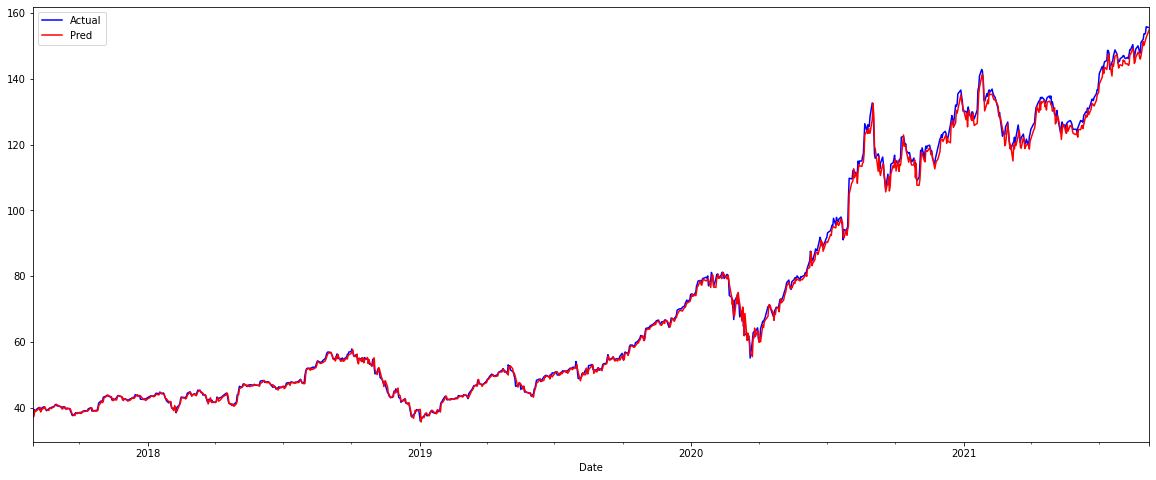

In [ ]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [ ]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
regression_results(predictions.Actual, predictions.Pred)

explained_variance:  0.9986
r2:  0.9983
MAE:  0.9701
MSE:  2.1284
RMSE:  1.4589


In [ ]:
# lets make like auto_arima suggests

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
ar_model = ARIMA(y_train, exog=X_train, order=(0, 1, 1), seasonal_order=(0,0,0,0), trend='t', freq=None)

In [ ]:
fitted = ar_model.fit()

In [ ]:
ar_predictions = fitted.predict(start=X_train.shape[0], end=X_train.shape[0] + X_test.shape[0] - 1, exog=X_test)

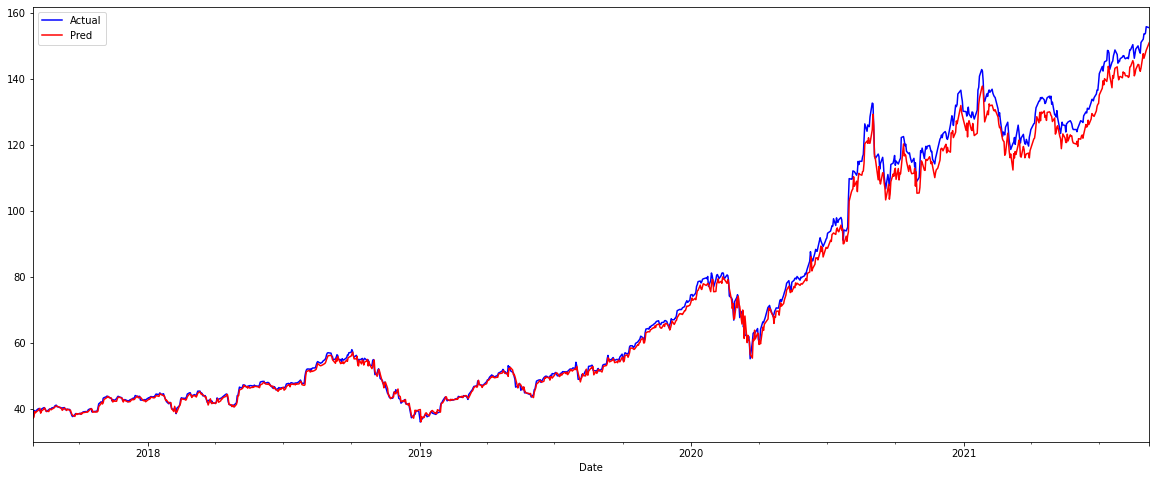

In [ ]:
ar_predictions = pd.DataFrame(ar_predictions)
ar_predictions.reset_index(drop=True, inplace=True)
ar_predictions.index = X_test.index
ar_predictions['Actual'] = y_test.Actual
ar_predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
ar_predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
ar_predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [ ]:
regression_results(ar_predictions.Actual, ar_predictions.Pred)

explained_variance:  0.9963
r2:  0.9941
MAE:  1.8652
MSE:  7.4867
RMSE:  2.7362


In [ ]:
# prophet
"""
Trend parameters

growth	linear’ or ‘logistic’ to specify a linear or logistic trend
changepoints	List of dates at which to include potential changepoints (automatic if not specified)
n_changepoints	If changepoints in not supplied, you may provide the number of changepoints to be automatically included
changepoint_prior_scale	Parameter for changing flexibility of automatic changepoint selection
 
Seasonality & Holiday Parameters

yearly_seasonality	Fit yearly seasonality
weekly_seasonality	Fit weekly seasonality
daily_seasonality	Fit daily seasonality
holidays	Feed dataframe containing holiday name and date
seasonality_prior_scale	Parameter for changing strength of seasonality model
holiday_prior_scale	Parameter for changing strength of holiday model
"""

In [ ]:
X_train, X_test = train_test_split(df.Close, test_size=0.1, shuffle=False)

In [ ]:
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.15, growth='linear')

In [ ]:
pro_df = pd.DataFrame(columns=['ds', 'y'])
pro_df.ds = df.index[:X_train.shape[0]]
pro_df.y = X_train.values

In [ ]:
model.fit(pro_df)

In [ ]:
forecast = model.make_future_dataframe(periods=X_test.shape[0]+100, freq='D')

In [ ]:
forecast = model.predict(forecast)  # forecast id large FataFrame of results

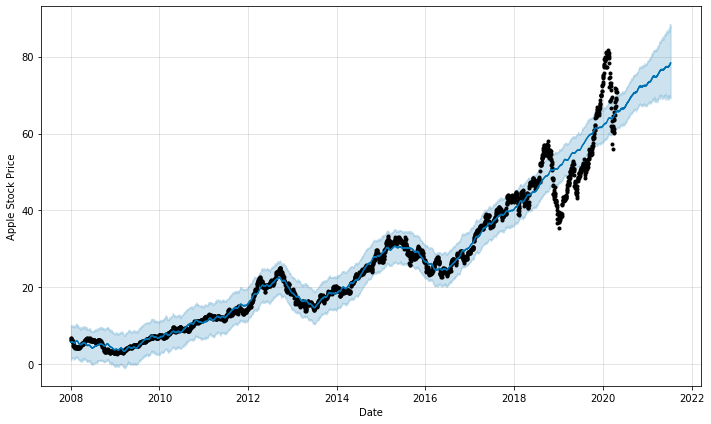

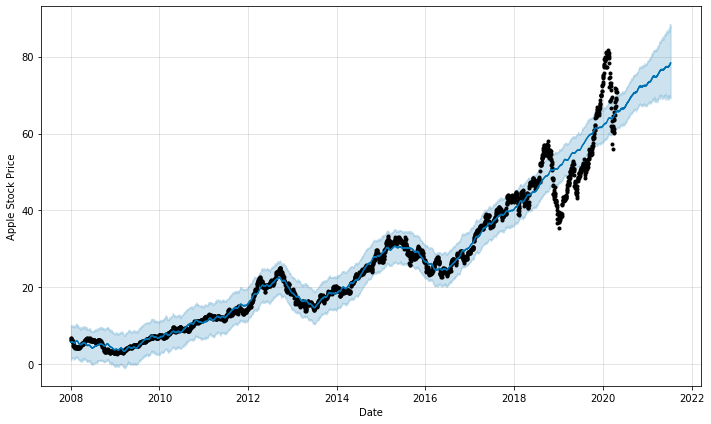

In [ ]:
model.plot(forecast, xlabel='Date', ylabel='Apple Stock Price')

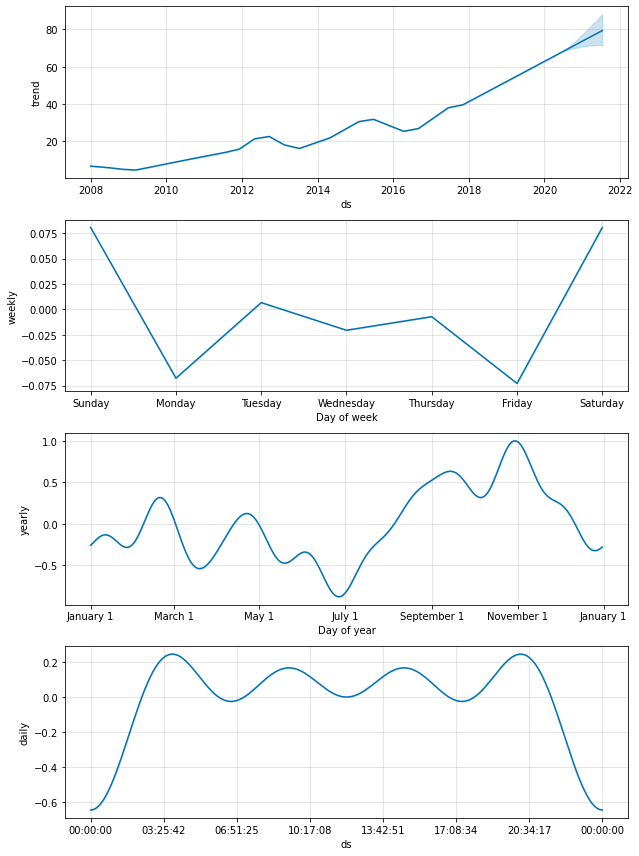

In [ ]:
fig = model.plot_components(forecast)
plt.show()

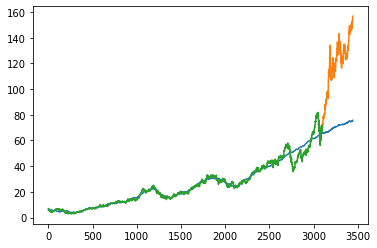

In [ ]:
plt.plot(forecast.yhat.values)
plt.plot(np.arange(X_train.shape[0], X_train.shape[0]+X_test.shape[0]), X_test.values)
plt.plot(X_train.values)
plt.show()
# because

In [ ]:
"""
- simple
simple_moving_average_close_stock = close_stock.rolling(window=30).mean()

- weighted 
weights = np.arange(1, 51)
open_MV = apple_data['Open'].rolling(50).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)

- exponential
expo_mv_close = apple_data['Close'].ewm(span=50, adjust=False).mean()
"""

In [ ]:
weights = np.linspace(0.1, 1, 60)  # makes no sense as if the season (if it exists) as we can see below
X_roll = df.drop('Close', axis=1).rolling(60).apply(lambda x: np.sum(weights * x)).dropna()
# y = df.Close[1:].rolling(60).apply(lambda x: np.sum(weights * x)).dropna()

In [ ]:
weights = np.arange(1, 61)
# X_roll = df['Close'].rolling(60).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True).dropna()
X_roll = df.drop('Close', axis=1).rolling(60).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True).dropna()

In [ ]:
X_roll.head()

,Open,High,Low,Adj Close,Volume,Mean,Actual,Dynamic
Date,,,,,,,,
2008-03-28,156.018156,159.295077,152.576826,133.908950,4.203840e+10,155.935951,155.936208,-0.059171
2008-03-31,155.965561,159.234368,152.638048,133.899978,4.146113e+10,155.936208,156.059082,-0.017026
2008-04-01,156.063371,159.353134,152.765030,134.099695,4.117320e+10,156.059082,156.303355,0.117767
2008-04-02,156.288493,159.566191,153.040519,134.296762,4.084275e+10,156.303355,156.659274,0.122163
2008-04-03,156.506305,159.917257,153.401290,134.641661,4.047293e+10,156.659274,157.116796,0.306043


In [ ]:
y = np.array([df.Close[item] for item in range(60, df.Close.shape[0])])

In [ ]:
X_roll = X_roll.iloc[:-1, :]

In [ ]:
X_roll.shape, y.shape

((3385, 8), (3385,))

In [ ]:
X_roll, y = X_roll.values, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_roll, y, test_size=0.3, shuffle=False)

In [ ]:
#X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1) # for 1 var

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lr = make_pipeline(MinMaxScaler(feature_range=(0,1)), LinearRegression())
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
regression_results(y_test, preds)

explained_variance:  0.9969
r2:  0.9958
MAE:  1.5104
MSE:  5.3604
RMSE:  2.3153


In [ ]:
lgbreg = LGBMRegressor(boosting_type='goss', num_leaves=31, max_depth=3, learning_rate=0.01, n_estimators=260,
                       subsample=1., colsample_bytree=1, random_state=1, reg_lambda=5., metric='mse')

In [ ]:
lgbreg.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=40, verbose=False)
preds = lgbreg.predict(X_test)

In [ ]:
regression_results(y_test, preds)

explained_variance:  -0.0009
r2:  -1.2795
MAE:  40.2763
MSE:  2892.163
RMSE:  53.7788


In [ ]:
# if taking previous X, y
lgbreg.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=False)
preds = lgbreg.predict(X_test)

In [ ]:
regression_results(y_test, preds)

explained_variance:  -0.0006
r2:  -1.3037
MAE:  40.6975
MSE:  2928.121
RMSE:  54.1121


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual,Dynamic
Date,,,,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.974743,1079178800,7.014464,6.965714,-0.158215
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.977503,842066400,6.965714,6.640893,-0.017143
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.521210,1455832000,6.640893,6.318393,-0.407143
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.447309,2072193200,6.318393,6.308215,-0.128928
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.251360,1523816000,6.308215,6.210714,-0.317500


In [ ]:
# make GRU

In [ ]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual,Dynamic
Date,,,,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.974743,1079178800,7.014464,6.965714,-0.158215
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.977503,842066400,6.965714,6.640893,-0.017143
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.521210,1455832000,6.640893,6.318393,-0.407143


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.optim as optim

In [ ]:
# Alternative
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3273

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
X_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
X_test = np.array(x_test)

In [ ]:
# below only for PyTorch, not Keras

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
#####################################################################################

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Mean"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 60

df_generated = generate_time_lags(df, input_dim)

In [ ]:
df_generated.head(1)

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual,Dynamic,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-03-31,5.116786,5.203929,5.09,5.125,4.40041,768065200,5.146965,5.236965,0.008214,5.111607,5.094643,5.113929,5.007678,4.901607,4.686964,4.713571,4.672678,4.484643,4.544643,4.508928,4.533036,4.455,4.33625,4.321964,4.434107,4.417679,4.38,4.356786,4.55375,4.606607,4.306071,4.22375,4.229107,4.256785,4.416607,4.397857,4.431965,4.484642,4.60375,4.560893,4.546786,4.5925,4.416072,4.322322,4.530179,4.694642,4.773571,4.799464,4.750893,4.740179,4.675714,4.636607,4.798215,4.869822,4.7525,5.463928,5.81,5.781785,5.81625,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,6.318393,6.640893,6.965714,7.014464


In [ ]:
df_features = (
                df_generated
                #.assign(year = df_generated.index.year)
                #.assign(hour = df_generated.index.hour)
                #.assign(day = df_generated.index.day)
                .assign(month = df_generated.index.month)
                #.assign(day_of_week = df_generated.index.dayofweek)
                #.assign(week_of_year = df_generated.index.week)
              )
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# removing cycles
df_features = generate_cyclical_features(df_features, 'month', 365, 0)

In [ ]:
df_features.head()

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual,Dynamic,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,sin_month,cos_month
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-16,5.901071,6.036071,5.596429,5.701429,4.895341,2213845200,5.816250,5.781785,-0.199642,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,6.318393,6.640893,6.965714,7.014464,0.017213,0.999852
2008-01-17,5.768214,5.905714,5.657857,5.746071,4.933671,1757859600,5.781785,5.810000,-0.022143,5.816250,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,6.318393,6.640893,6.965714,0.017213,0.999852
2008-01-18,5.775357,5.919643,5.700357,5.762857,4.948083,1724343600,5.810000,5.463928,-0.012500,5.781785,5.816250,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,6.318393,6.640893,0.017213,0.999852
2008-01-22,5.287857,5.713571,5.214286,5.558571,4.772681,2434754000,5.463928,4.752500,0.270714,5.810000,5.781785,5.816250,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,6.318393,0.017213,0.999852
2008-01-23,4.863929,5.000000,4.505000,4.966786,4.264564,3372969600,4.752500,4.869822,0.102857,5.463928,5.810000,5.781785,5.816250,6.140714,6.331964,6.211607,6.364465,6.210714,6.308215,0.017213,0.999852


In [ ]:
df_features = df.copy()

In [ ]:
X, y = df_features.drop(['Close', 'Actual'], axis=1), df_features.Close
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)  # transform first as if the samples are not independent in time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [ ]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
# add one GRU and one Linear
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, int(hidden_dim/2))
        self.fc2 = nn.Linear(int(hidden_dim/2), output_dim)

    def forward(self, x):

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())  # try using bert instead

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [ ]:
# https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [ ]:
from torchsummary import summary

In [ ]:
summary(GRUModel(**model_params), (8, 69)) # 3 1928 8

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 8, 128], [-1, 2, 128]]               0
            Linear-2                   [-1, 64]           8,256
            Linear-3                    [-1, 1]              65
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.00
Params size (MB): 0.03
Estimated Total Size (MB): 2.03
----------------------------------------------------------------


In [ ]:
class Optimization:

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.scheduler = scheduler
        
    def train_step(self, x, y):

        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        # model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
            self.scheduler.step()
            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().numpy())
                values.append(y_test.detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 128
layer_dim = 3
batch_size = 8
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRUModel(**model_params).to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

[1/100] Training loss: 5.7835	 Validation loss: 24.2430
[2/100] Training loss: 12.3044	 Validation loss: 23.5945
[3/100] Training loss: 18.3997	 Validation loss: 25.5591
[4/100] Training loss: 19.6856	 Validation loss: 28.1741
[5/100] Training loss: 22.3258	 Validation loss: 29.3466
[6/100] Training loss: 21.1506	 Validation loss: 31.6753
[7/100] Training loss: 23.0794	 Validation loss: 31.4243
[8/100] Training loss: 15.9673	 Validation loss: 27.9883
[9/100] Training loss: 20.8590	 Validation loss: 32.0553
[10/100] Training loss: 18.7521	 Validation loss: 32.1116
[50/100] Training loss: 1.2651	 Validation loss: 8.0259
[100/100] Training loss: 0.7496	 Validation loss: 6.4290


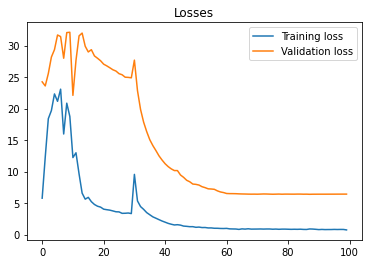

In [ ]:
opt.train(train_loader, valid_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [ ]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# only for var 1
predictions = scaler.inverse_transform(np.array(predictions).squeeze(1))

In [ ]:
regression_results(np.array(values).squeeze(), np.array(predictions).squeeze())

explained_variance:  0.0007
r2:  -1.3589
MAE:  41.5338
MSE:  2992.9597
RMSE:  54.708


In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title(f'Model: {model.__class__.__name__}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train = X_train[..., None]
X_test = X_test[..., None]
model.input_shape

(None, 60, 1)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # add lr callbacks, early_stopping?

# Train the model
model.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
402/402 [==============================] - 32s 71ms/step - loss: 6.1489e-04 - val_loss: 17809.6191
Epoch 2/10
402/402 [==============================] - 28s 69ms/step - loss: 2.6359e-04 - val_loss: 17820.2754
Epoch 3/10
402/402 [==============================] - 28s 69ms/step - loss: 1.4569e-04 - val_loss: 17826.3047
Epoch 4/10
402/402 [==============================] - 28s 68ms/step - loss: 1.4325e-04 - val_loss: 17830.1191
Epoch 5/10
402/402 [==============================] - 28s 69ms/step - loss: 1.2226e-04 - val_loss: 17823.7480
Epoch 6/10
402/402 [==============================] - 28s 69ms/step - loss: 1.8508e-04 - val_loss: 17812.6621
Epoch 7/10
402/402 [==============================] - 28s 69ms/step - loss: 9.8406e-05 - val_loss: 17828.0371
Epoch 8/10
402/402 [==============================] - 28s 69ms/step - loss: 1.0669e-04 - val_loss: 17820.9648
Epoch 9/10
402/402 [==============================] - 28s 69ms/step - loss: 1.1143e-04 - val_loss: 17824.1797
Epoch 10/1

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

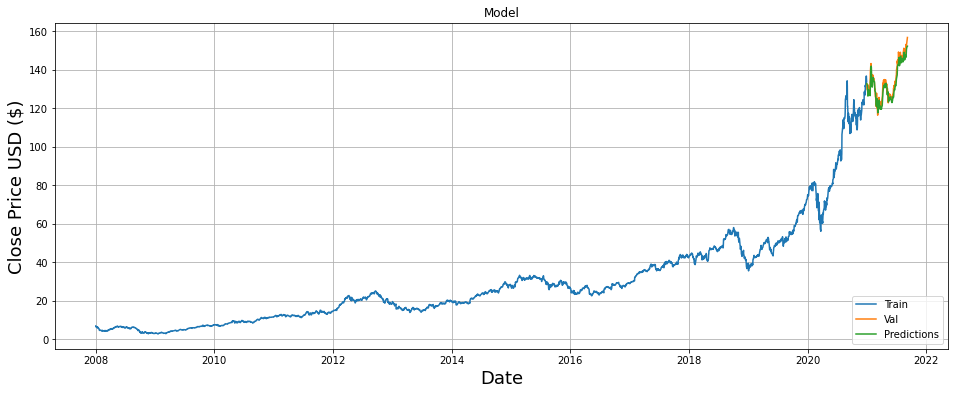

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.grid()
plt.show()

In [ ]:
regression_results(y_test, predictions)

explained_variance:  0.9411
r2:  0.9124
MAE:  2.3278
MSE:  8.049
RMSE:  2.8371
